Dataset A sheets loaded:
Sheet Sheet1: (32, 1)
                AALON.D
Index name             
2022-01-01  2073.833663
2022-02-01  2308.790793
2022-03-01  2600.382764
2022-04-01  2418.381642
2022-05-01  1873.597946
Dataset B after resampling to monthly frequency:
(31, 1)
             PALC_LME.D
Mnemonic               
2022-01-31  3059.333333
2022-02-28  3260.825000
2022-03-31  3537.847826
2022-04-30  3256.578947
2022-05-31  2826.357143
Dataset X loaded:
(1, 2)
  Column_A    Column_B
0  AALON.D  PALC_LME.D
Processing pair: AALON.D and PALC_LME.D
Merged DataFrame shape: (31, 2)
First non-null occurrence: 2022-01-31 00:00:00
Result DataFrame shape: (31, 2)
             AALON.D  PALC_LME.D
Date                            
2022-01-31  1.000000    1.000000
2022-02-28  1.113296    1.065861
2022-03-31  1.253901    1.156411
2022-04-30  1.166141    1.064473
2022-05-31  0.903447    0.923847


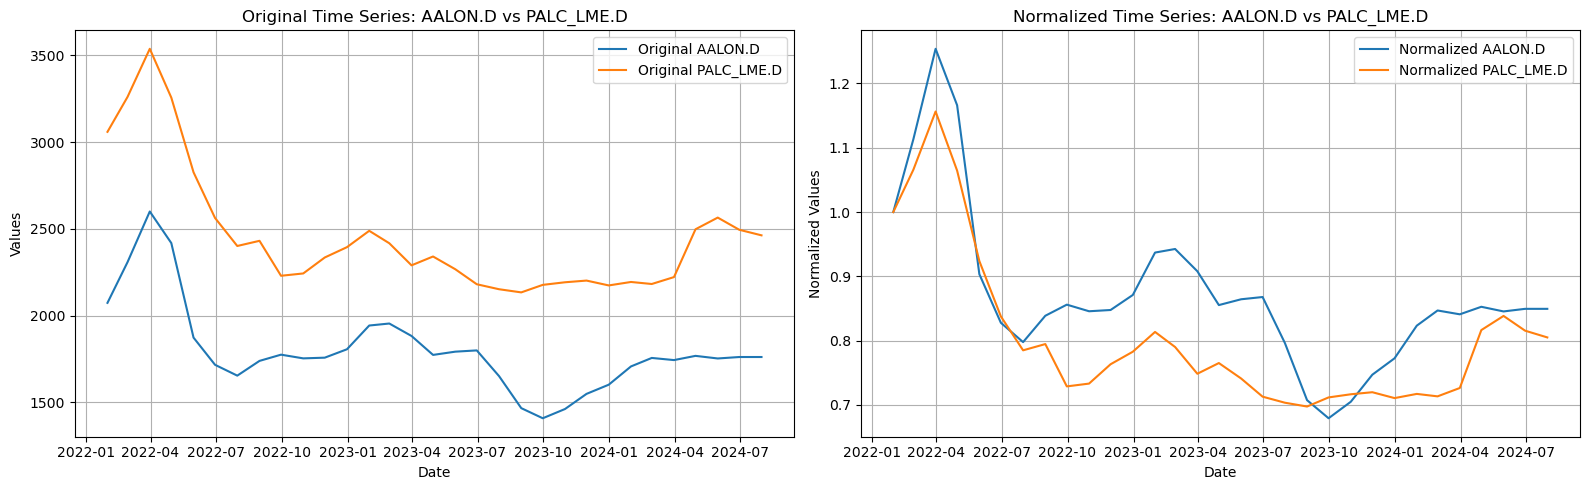

Plots saved successfully and displayed in the notebook.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define the file paths
file_a = r'C:\Users\ardas\Downloads\Normal A\a.xlsx'
file_bm = r'C:\Users\ardas\Downloads\Normal A\bm.xlsx'
file_x = r'C:\Users\ardas\Downloads\Normal A\x.xlsx'
output_dir = r'C:\Users\ardas\Downloads\Normal\output'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Read dataset A (all sheets)
df_a_sheets = pd.read_excel(file_a, sheet_name=None, header=0, index_col=0)
print("Dataset A sheets loaded:")
for sheet_name, df in df_a_sheets.items():
    print(f"Sheet {sheet_name}: {df.shape}")
    print(df.head())

# Read dataset Bm (multiple sheets) and convert each to monthly frequency
bm_sheets = pd.read_excel(file_bm, sheet_name=None, header=0, index_col=0)
df_b = pd.concat([sheet.resample('M').mean() for sheet in bm_sheets.values()], axis=1)
print("Dataset B after resampling to monthly frequency:")
print(df_b.shape)
print(df_b.head())

# Read dataset X
df_x = pd.read_excel(file_x, header=0)
print("Dataset X loaded:")
print(df_x.shape)
print(df_x.head())

# Function to find a column in the dictionary of DataFrames
def find_column(df_dict, col_name):
    for sheet_name, df in df_dict.items():
        if col_name in df.columns:
            return df[col_name]
    return None

# Iterate through each pair in dataset X
for idx, row in df_x.iterrows():
    col_a = row['Column_A']
    col_b = row['Column_B']
    print(f"Processing pair: {col_a} and {col_b}")

    # Find columns in datasets A and B
    series_a = find_column(df_a_sheets, col_a)
    series_b = df_b[col_b] if col_b in df_b.columns else None

    if series_a is not None and series_b is not None:
        # Resample to monthly frequency and interpolate missing values
        series_a = series_a.resample('M').mean().interpolate(method='linear')
        series_b = series_b.resample('M').mean().interpolate(method='linear')

        # Merge the series on the index (date)
        merged_df = pd.merge(series_a, series_b, left_index=True, right_index=True, suffixes=('_a', '_b'))
        print(f"Merged DataFrame shape: {merged_df.shape}")

        # Find the first occurrence where both columns have non-null values
        non_null_mask = merged_df.notnull().all(axis=1)
        if non_null_mask.any():
            first_occurrence = merged_df[non_null_mask].index[0]
            print(f"First non-null occurrence: {first_occurrence}")

            # Get the values at this row
            at = merged_df.loc[first_occurrence, series_a.name]
            bt = merged_df.loc[first_occurrence, series_b.name]

            # Normalize the data
            normalized_a = merged_df[series_a.name] / at
            normalized_b = merged_df[series_b.name] / bt

            # Create the resulting DataFrame
            result_df = pd.DataFrame({
                'Date': merged_df.index,
                series_a.name: normalized_a,
                series_b.name: normalized_b
            }).set_index('Date')
            print(f"Result DataFrame shape: {result_df.shape}")
            print(result_df.head())

            # Plot the unconverted pair
            fig, axes = plt.subplots(1, 2, figsize=(16, 5))  # Wider and less tall
            axes[0].plot(merged_df.index, merged_df[series_a.name], label=f'Original {series_a.name}')
            axes[0].plot(merged_df.index, merged_df[series_b.name], label=f'Original {series_b.name}')
            axes[0].set_xlabel('Date')
            axes[0].set_ylabel('Values')
            axes[0].set_title(f'Original Time Series: {series_a.name} vs {series_b.name}')
            axes[0].legend()
            axes[0].grid(True)

            # Plot the converted pair
            axes[1].plot(result_df.index, result_df[series_a.name], label=f'Normalized {series_a.name}')
            axes[1].plot(result_df.index, result_df[series_b.name], label=f'Normalized {series_b.name}')
            axes[1].set_xlabel('Date')
            axes[1].set_ylabel('Normalized Values')
            axes[1].set_title(f'Normalized Time Series: {series_a.name} vs {series_b.name}')
            axes[1].legend()
            axes[1].grid(True)

            # Adjust layout and save the plot
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f'comparison_{col_a}_vs_{col_b}.png'))
            plt.show()
            plt.close(fig)
        else:
            print(f"No common non-null data points found for pair: {col_a} and {col_b}")
    else:
        print(f"Column not found for pair: {col_a} and/or {col_b}")

print("Plots saved successfully and displayed in the notebook.")
